Part 1 of **time forecasting with energy**

In [7]:
# LOAD THE REPOSITORY
# if you are working from outside the repository
# this happens if you use colab like me, and start with the notebook
!git clone https://github.com/sandeshbhatjr/energy-prediction.git
!pip install -U --quiet workalendar astral entsoe-py pandas statsmodels

Cloning into 'energy-prediction'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 116 (delta 36), reused 93 (delta 17), pack-reused 0
Receiving objects: 100% (116/116), 7.95 MiB | 18.39 MiB/s, done.
Resolving deltas: 100% (36/36), done.
     |████████████████████████████████| 163kB 3.5MB/s 
     |████████████████████████████████| 8.7MB 10.8MB/s 
     |████████████████████████████████| 266kB 46.9MB/s 
     |████████████████████████████████| 16.0MB 48.3MB/s 
     |████████████████████████████████| 235kB 50.7MB/s 


In [0]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from urllib.parse import urljoin

# Data extraction

For the EU energy market, the `ENTSOE` platform provides an abundant level of information, ranging from generation to load forecasts, day ahead prices to balancing costs. The data is both directly accessible on their platform as well as through an API, for which you have to request an API key. The deployed version of this project infact utilises this API. Here, though, I have just used the data from SMARD (whose source, if I am not mistaken, is also ENTSOE), postponing the work of going through the API to the end.

The data at SMARD is given in .csv format and encompasses all the day-ahead prices starting from 2015 until the current date. This is convenient for analysis though for whatever reasons, they only allow us to download in intervals of 2 years, so our data is split amongst three .csv files. This needs to be combined into a single dataframe.

In [0]:
root_path = 'energy-prediction/data/Germany/day-ahead-price/'
df1 = pd.read_csv(urljoin(root_path, 'Day-ahead_prices_201501010000_201701012359_1.csv'), sep=';')
df2 = pd.read_csv(urljoin(root_path, 'Day-ahead_prices_201701010000_201901012359_1.csv'), sep=';')
df3 = pd.read_csv(urljoin(root_path, 'Day-ahead_prices_201901010000_202002062359_1.csv'), sep=';')
df = df1.append(df2[df2['Date'] != 'Jan 1, 2017']).append(df3[df3['Date'] != 'Jan 1, 2019'])

Now, to do some typical data type conversion steps to make it easier for selection with pandas (which also yields some performance benefits).

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df['Time of day'] = pd.to_datetime(df['Time of day']).dt.time
df.replace('-', 'NaN', inplace=True)
countries = list(filter(lambda x: x.endswith('[Euro/MWh]'), sorted(df)))
for country in countries:
  df[country] = df[country].astype('float')
df['timedate'] = pd.to_datetime(df['Date'].astype('str') + ' ' + df['Time of day'].astype('str'))
df.set_index('timedate', drop=True, inplace=True)
df.index.name = None
df.drop(columns=['Date', 'Time of day'], inplace=True)

df.sample(2)

,Germany/Luxembourg[Euro/MWh],Denmark 1[Euro/MWh],Denmark 2[Euro/MWh],France[Euro/MWh],Northern Italy[Euro/MWh],Netherlands[Euro/MWh],Poland[Euro/MWh],Sweden 4[Euro/MWh],Switzerland[Euro/MWh],Slovenia[Euro/MWh],Czech Republic[Euro/MWh],Hungary[Euro/MWh],Austria[Euro/MWh],Germany/Austria/Luxembourg[Euro/MWh]
2018-02-03 09:00:00,NaN,35.05,37.08,45.45,NaN,45.45,NaN,37.08,49.7,45.45,44.26,44.26,NaN,45.45
2018-01-06 00:00:00,NaN,29.45,29.45,29.45,NaN,29.45,NaN,29.45,35.2,29.45,27.50,27.50,NaN,29.45


**Some data cleaning** is in order; there should be 24 day-ahead prices corresponding to each hour of a day. Let's see if our data matches this requirement.

In [11]:
unique, counts = np.unique(df.index.date, return_counts=True)
np.all(counts == 24) # Does each day have 24 prices?

False

It doesn't! Let's explore further by looking at the defaulting dates.

In [12]:
unique[counts != 24].tolist() # Which days don't?

[datetime.date(2015, 3, 29),
 datetime.date(2015, 10, 25),
 datetime.date(2016, 3, 27),
 datetime.date(2016, 10, 30),
 datetime.date(2017, 3, 26),
 datetime.date(2017, 10, 29),
 datetime.date(2018, 3, 25),
 datetime.date(2018, 10, 28),
 datetime.date(2019, 3, 31),
 datetime.date(2019, 10, 27)]

If you examine it carefully, you will realise that the above list of dates correpond to when the time shifts because of **Daylight Savings Time (DST)**, so the missing entry is because of the hour skipped due to the change. I will tackle this by localising to UTC+1, which corresponds to the standard CET without the shift from DST. This is in fact very tricky thing to handle, cause day-ahead prices- one can assume- are influenced both by time-zones as well as environmental factors which are not influenced by the time-change. We will add an additional column to signal this change of time in a separate column. While we can expect deep learning models to accomodate well with this shift through the extra dummy index, we can expect simple regression to have problems because of this change. Further details are explored in the supplement, but we take the simple approach for now.

First, create a simple function to compute when DST occurs given a year.

In [0]:
def when_is_DST(year):
  # get day of last date
  end_of_march = (dt.datetime(year, 4, 1, 3, 0) - dt.timedelta(days=1))
  end_of_october = (dt.datetime(year, 11, 1, 2, 0) - dt.timedelta(days=1))
  # some modular arithmetic to compute how far it is from the last Sunday
  days_after_last_sunday_of_march = (end_of_march.weekday() + 1) % 7
  days_after_last_sunday_of_october = (end_of_october.weekday() + 1) % 7
  last_sunday_of_march = end_of_march - dt.timedelta(days=days_after_last_sunday_of_march)
  last_sunday_of_october = end_of_october - dt.timedelta(days=days_after_last_sunday_of_october)
  return last_sunday_of_march, last_sunday_of_october

Next, we create a new index with the changes.

In [14]:
# express in UTC
UTC_datetime_index = df \
  .tz_localize(tz='Europe/Berlin', ambiguous='infer') \
  .index \
  .tz_convert(None)

# convert to UTC+1
CET_datetime_index = UTC_datetime_index + pd.to_timedelta(1, unit='h')

# check the index, again
unique, counts = np.unique(CET_datetime_index.date, return_counts=True)
np.all(counts == 24) # Does each day have 24 prices?

True

That passes our test. Finally, make the changes to our dataframe.

In [15]:
# Add the corrected index to our dataframe
df.set_index(CET_datetime_index, inplace=True)
# Add an extra column for the dummy index DST
df['Daylight Savings Time'] = 0
for year in range(2015, 2020):
  start_of_DST, end_of_DST = when_is_DST(year)
  df.loc[start_of_DST:end_of_DST, 'Daylight Savings Time'] = 1

df.sample(5)

,Germany/Luxembourg[Euro/MWh],Denmark 1[Euro/MWh],Denmark 2[Euro/MWh],France[Euro/MWh],Northern Italy[Euro/MWh],Netherlands[Euro/MWh],Poland[Euro/MWh],Sweden 4[Euro/MWh],Switzerland[Euro/MWh],Slovenia[Euro/MWh],Czech Republic[Euro/MWh],Hungary[Euro/MWh],Austria[Euro/MWh],Germany/Austria/Luxembourg[Euro/MWh],Daylight Savings Time
2017-02-11 05:00:00,NaN,31.66,31.66,44.86,49.35,40.10,31.66,31.66,48.35,49.35,34.50,36.85,NaN,37.50,0
2015-02-14 01:00:00,NaN,27.20,27.20,36.19,60.27,36.19,NaN,27.20,40.62,60.27,25.47,37.91,NaN,30.05,0
2015-10-28 10:00:00,NaN,28.85,28.85,57.03,57.03,42.56,43.29,28.85,54.10,42.34,44.20,45.30,NaN,39.93,0
2015-10-06 21:00:00,NaN,12.39,12.39,38.51,43.98,39.32,31.44,12.39,36.36,43.98,28.72,44.95,NaN,30.05,1
2015-09-06 08:00:00,NaN,3.20,17.36,13.96,43.10,29.35,33.98,17.36,17.71,43.10,-0.10,48.08,NaN,3.20,1


We are interested in the german electricity market, so we can just extract the prices for that specific column. But a look at the data reveals that there are two columns associated with Germany: `Germany/Luxembourg[Euro/MWh]` and `Germany/Austria/Luxembourg[Euro/MWh]`. This is because until October 2018- Germany, Austria and Luxembourg used to be in the same bidding zone, but this was changed to relieve congestion between the two countries, by splitting Austria into a separate zone (see `[SMARD]` for details). We will combine both these datapoints into one single dataset consisting of day-ahead prices from 2015 until now, and add a column to indicate the change in bidding zone.

In [16]:
# the following should be empty for consistency
c1 = df['Germany/Luxembourg[Euro/MWh]'].notnull()
c2 = df['Germany/Austria/Luxembourg[Euro/MWh]'].notnull()
np.all(~(c1 & c2))

True

In [17]:
pre_2018_german_df = \
df[['Daylight Savings Time', 'Germany/Austria/Luxembourg[Euro/MWh]']] \
[:dt.datetime(2018, 9, 30, 22, 0, 0)] \
.copy() \
.rename(columns={'Germany/Austria/Luxembourg[Euro/MWh]': 'Day Ahead Price'})
pre_2018_german_df['Bidding Zone'] = 'DE-AT-LU'

post_2018_german_df = \
df[['Daylight Savings Time', 'Germany/Luxembourg[Euro/MWh]']] \
[dt.datetime(2018, 9, 30, 23, 0, 0):] \
.copy() \
.rename(columns={'Germany/Luxembourg[Euro/MWh]': 'Day Ahead Price'})
post_2018_german_df['Bidding Zone'] = 'DE-LU'

german_df = pre_2018_german_df.append(post_2018_german_df)

german_df.sample(5)

,Daylight Savings Time,Day Ahead Price,Bidding Zone
2016-06-21 15:00:00,1,32.45,DE-AT-LU
2018-06-29 03:00:00,1,33.96,DE-AT-LU
2019-08-20 18:00:00,1,53.86,DE-LU
2017-12-23 07:00:00,0,10.71,DE-AT-LU
2016-06-09 03:00:00,1,21.11,DE-AT-LU


**Data imputation strategy**

There will be some algorithms further up which handle missing values badly, so let's see if there are missing values.

In [18]:
missing_values_index = np.unique(german_df[german_df['Day Ahead Price'].isnull()].index.date).tolist()
sorted(missing_values_index)

[datetime.date(2015, 1, 1),
 datetime.date(2015, 1, 2),
 datetime.date(2015, 1, 3),
 datetime.date(2015, 1, 4),
 datetime.date(2015, 1, 5),
 datetime.date(2019, 7, 30),
 datetime.date(2019, 7, 31),
 datetime.date(2019, 9, 2),
 datetime.date(2019, 9, 3),
 datetime.date(2020, 1, 31)]

Those aren't too many values: for now, it suffices to do a simple imputation. The strategy will be as follows: for each hour, isolate contiguous units of missing values, and fill them in a linear fashion. This is necessary as excluding points in between the time series will cause a lot of issues for most time-series based algorithms (where maintaining the unit time-step between two terms the same is rather crucial for the analysis). As for missing values in the beginning and the end, just exclude them from the analysis.

First, the following function defines a way to group contiguous blocks for easy access.

In [19]:
def group_contiguous_points(datetime_list): 
  datetime_array = np.array(datetime_list) 
  reversed_datetime_array = np.flip(datetime_array)
  forward_difference = (datetime_array[1:] - datetime_array[:-1])
  backward_difference = np.flip(reversed_datetime_array[1:] - reversed_datetime_array[:-1])
  contiguous_forward_mask = np.concatenate([[True], (forward_difference != dt.timedelta(1))])
  contiguous_backward_mask = np.concatenate([(backward_difference != dt.timedelta(-1)), [True]])
  # zip the index of True
  contiguous_index = np.concatenate([np.where(contiguous_forward_mask), np.where(contiguous_backward_mask)]).T
  contiguous_datetimes = [(datetime_list[i1], datetime_list[i2]) for (i1, i2) in contiguous_index.tolist()]
  return contiguous_datetimes

group_contiguous_points(missing_values_index)

[(datetime.date(2015, 1, 1), datetime.date(2015, 1, 5)),
 (datetime.date(2019, 7, 30), datetime.date(2019, 7, 31)),
 (datetime.date(2019, 9, 2), datetime.date(2019, 9, 3)),
 (datetime.date(2020, 1, 31), datetime.date(2020, 1, 31))]

Next, we do our imputation.

In [54]:
def impute(df, col, verbose=True):
  imputed_df = df.copy(deep=True)
  for time in np.unique(df.index.time):
    if verbose:
      print(time)
    df_at_time = imputed_df[imputed_df.index.time == time]
    missing_values_index_at_h = np.unique(df_at_time[df_at_time[col].isnull()].index.date).tolist()
    for start, end in group_contiguous_points(missing_values_index_at_h):
      start_time = dt.datetime.combine(start, time)
      end_time = dt.datetime.combine(end, time)
      try:
        prev_date_value = df_at_time.loc[start_time + dt.timedelta(-1), col]
      except KeyError as e:
        if verbose:
          print("Data at beginning skipped and date entry removed: {}-{}".format(start, end))
        imputed_df.drop(imputed_df.loc[start:end+dt.timedelta(1)].index, inplace=True)
        continue
      try:
        next_date_value = df_at_time.loc[end_time + dt.timedelta(1), col]
      except KeyError as e:
        if verbose:
          print("Data at end skipped: {}-{}".format(start, end))
        imputed_df.drop(imputed_df.loc[start:].index, inplace=True)
        continue
      # linear fitting
      number_of_days = (end - start).days + 1
      grad = (next_date_value - prev_date_value) / (number_of_days + 1)
      imputation_list = [prev_date_value + (grad * i) for i in range(1, number_of_days+1)]
      # impute the values
      for i in range(number_of_days):
        if verbose:
          print("{} imputed".format(start_time + dt.timedelta(i)))
        imputed_df.loc[start_time + dt.timedelta(i), col] = imputation_list[i]
  print
  assert np.all(imputed_df[col].notnull()) == True
  return imputed_df

imputed_german_df = impute(german_df, 'Day Ahead Price')

00:00:00
Data at beginning skipped and date entry removed: 2015-01-01-2015-01-05
2019-07-31 00:00:00 imputed
2019-09-03 00:00:00 imputed
2020-01-31 00:00:00 imputed
01:00:00
2019-07-31 01:00:00 imputed
2019-09-03 01:00:00 imputed
2020-01-31 01:00:00 imputed
02:00:00
2019-07-31 02:00:00 imputed
2019-09-03 02:00:00 imputed
2020-01-31 02:00:00 imputed
03:00:00
2019-07-31 03:00:00 imputed
2019-09-03 03:00:00 imputed
2020-01-31 03:00:00 imputed
04:00:00
2019-07-31 04:00:00 imputed
2019-09-03 04:00:00 imputed
2020-01-31 04:00:00 imputed
05:00:00
2019-07-31 05:00:00 imputed
2019-09-03 05:00:00 imputed
2020-01-31 05:00:00 imputed
06:00:00
2019-07-31 06:00:00 imputed
2019-09-03 06:00:00 imputed
2020-01-31 06:00:00 imputed
07:00:00
2019-07-31 07:00:00 imputed
2019-09-03 07:00:00 imputed
2020-01-31 07:00:00 imputed
08:00:00
2019-07-31 08:00:00 imputed
2019-09-03 08:00:00 imputed
2020-01-31 08:00:00 imputed
09:00:00
2019-07-31 09:00:00 imputed
2019-09-03 09:00:00 imputed
2020-01-31 09:00:00 impute

In [0]:
# drop the first few
indices_to_drop = german_df[dt.datetime(2015,1,1,0,0,0):dt.datetime(2015,1,5,23,0,0)].index
german_df.drop(indices_to_drop, inplace=True)

# replace the rest
german_df.loc[dt.datetime(2019,9,2,23,0,0), 'Day Ahead Price'] = \
  (german_df.loc[dt.datetime(2019,9,1,23,0,0), 'Day Ahead Price'] + \
   german_df.loc[dt.datetime(2019,9,3,23,0,0), 'Day Ahead Price'])/2
german_df.loc[dt.datetime(2019,7,30,23,0,0), 'Day Ahead Price'] = \
  (german_df.loc[dt.datetime(2019,7,29,23,0,0), 'Day Ahead Price'] + \
   german_df.loc[dt.datetime(2019,7,31,23,0,0), 'Day Ahead Price'])/2
for i in range(23):
  german_df.loc[dt.datetime(2019,9,3,i,0,0), 'Day Ahead Price'] = \
    (german_df.loc[dt.datetime(2019,9,2,i,0,0), 'Day Ahead Price'] + \
     german_df.loc[dt.datetime(2019,9,4,i,0,0), 'Day Ahead Price'])/2
  german_df.loc[dt.datetime(2019,7,31,i,0,0), 'Day Ahead Price'] = \
    (german_df.loc[dt.datetime(2019,7,30,i,0,0), 'Day Ahead Price'] + \
     german_df.loc[dt.datetime(2019,8,1,i,0,0), 'Day Ahead Price'])/2
for i in range(24):
  german_df.loc[dt.datetime(2020,1,31,i,0,0), 'Day Ahead Price'] = \
    (german_df.loc[dt.datetime(2020,1,30,i,0,0), 'Day Ahead Price'] + \
     german_df.loc[dt.datetime(2020,2,1,i,0,0), 'Day Ahead Price'])/2

# check
german_df['Date'][german_df['Day Ahead Price'].isnull()].unique()

array([], dtype='datetime64[ns]')

There! The first level of data cleaning and preparation is done. We can proceed to analyse and explore our dataset.

# Trend and seasonality

A typical characteristic of a time series is its decomposition into trend, seasonal and residual parts. Seasonal contributions represent recurrent patterns in the series, hence help in better forecasting in the long run.

Classical decomposition techniques include X11, SEATS, STL and fourier-based algorithms. We will look at STL and fourier one for now.

#### STL decomposition

A standard algorithm for the decomposition of the time-series into trend, seasonality and the residual is the STL method.

In [0]:
import statsmodels.api as sm

pdf = german_df.loc[german_df['Hour'] == 6, 'Day Ahead Price']

with mpl.rc_context():
  mpl.rc("figure", figsize=(12,8))
  sm.tsa.seasonal_decompose(pdf, period=365).plot()
  result = sm.tsa.stattools.adfuller(pdf)

KeyError: ignored

#### Autocorrelation of the time series

A very useful way to check seasonality is to see if there is a correlation of the time-series with its lagged version. The lags for which there is high correlation indicate a seasonality with that time-period. This is precisely the information encoded in an autocorrelation function which we will plot now.

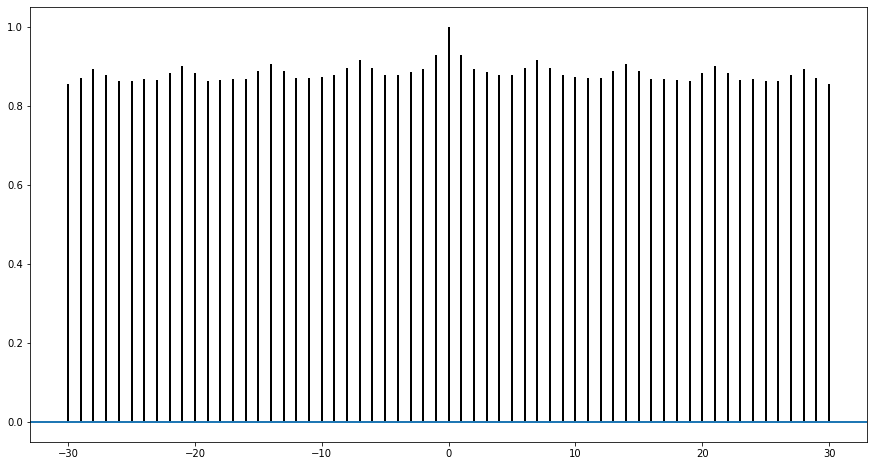

In [0]:
plt.figure(figsize=(15,8))
lags, c, _, _ = plt.acorr(german_df.sort_values(by='Date') \
  .loc[german_df['Hour'] == 5, 'Day Ahead Price'], usevlines=True, normed=True, maxlags=30, lw=2)

The plot above seems to indicate a slight weekly pattern.

In [0]:
ac_df = pd.DataFrame({'lags':lags, 'ac' : c})
highly_ac_list = ac_df.sort_values(by='ac', ascending=False).head(40)['lags'].to_list()
list(filter(lambda x: x>0, highly_ac_list)) # it is symmetric across a change in sign

[1, 7, 14, 21, 8, 6, 2, 28, 15, 13, 3, 22, 20, 4, 5, 9, 27, 10, 12]

#### Fourier space and the spectrum
If you come from a background in physics like I do, you are probably already screaming- why don't you operate on the *fourier space*? Yes, I hear you. Fourier decomposition is great at finding the seasonal and trend patterns in the data. Terms on the lower end of the spectrum (low frequency) can be interpreted as the ones which reveal the trend, while the ones on the higher end can be associated with seasons. It is also quite easy to distinguish the noise by identifying the low amplitude ones (and especially high frequency, low amplitude ones). This gives a very versatile method to deseasonalise/detrend/denoise the data.

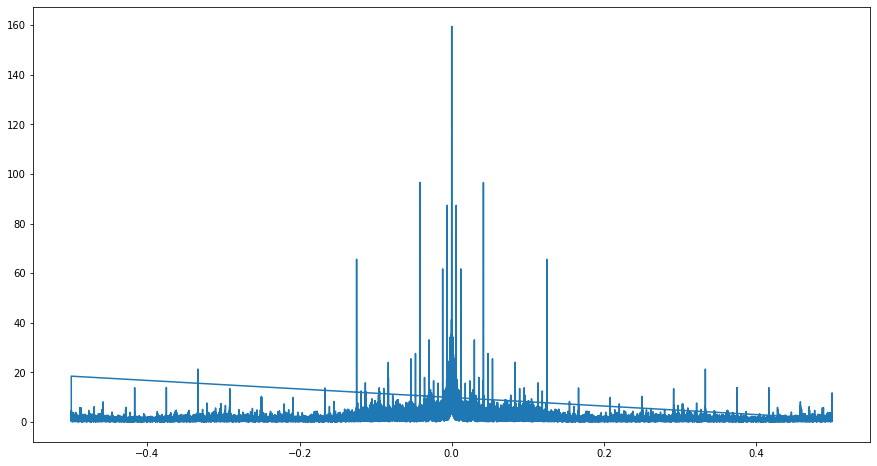

In [0]:
from numpy.fft import fft
from numpy.fft import fftfreq

ft = fft(german_df.sort_values(by='Date').loc[:, 'Day Ahead Price'])
ft_norm = list(map(lambda x: np.sqrt(x.real**2 + x.imag**2)/1000, ft))
freq = fftfreq(len(ft_norm))

plt.figure(figsize=(15,8))
plt.plot(freq[1:], ft_norm[1:])

#### Constructing lagged features

A typical way to incorporate non-local features into our dataset is to consider lagged features. The question then is what lag time should we consider?

# Daily, weekly, monthly, and annual patterns

In [0]:
german_df['Hour'] = german_df.index.hour
german_df['Day of Week'] = german_df.index.weekday
german_df['Day'] = german_df.index.day
german_df['Month'] = german_df.index.month
german_df['Year'] = german_df.index.year

**Daily patterns**

There must be some daily patterns in the prices, cause the consumption- I am guessing- has similar patterns everyday especially on a regular workday. This obviously changes when it is a weekend, or a holiday, so let's see what the data has to say about daily patterns.

First up, let us look at an aggregrated data of prices grouped by time of day. We want to see mean usage over the day, and how much this varies across different dates. A box plot is well suited for this.

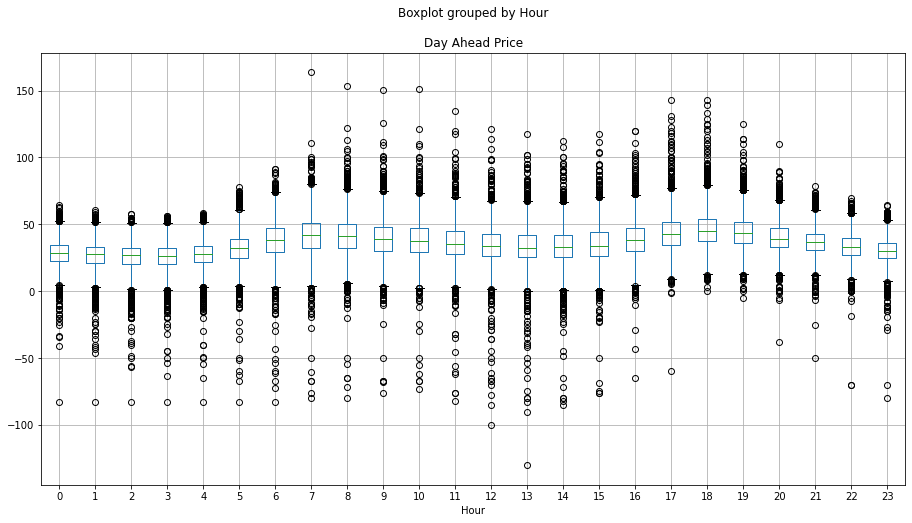

In [0]:
german_df.boxplot(column=['Day Ahead Price'], by='Hour', figsize=(15,8))

Seems like it has twin peaks of usage: typically around 8:00 and 19:00 each day. Sounds perfectly reasonable. Further, the variance in prices is more during 6:00 to 20:00, and lesser during the rest, especially the spikes in prices.

> Why are there negative values? Do they really pay to give away electricity in these intervals? Apparently they do, as weird as it might seem.

In [0]:
def plotDailyAheadPrice(date, color, axes, opacity=1):
  german_df['Hour'] = german_df['Hour'].astype('float')
  german_df[['Hour', 'Day Ahead Price']][german_df['Date'] == date] \
  .plot.line(
      'Hour', 'Day Ahead Price', 
       figsize=(15, 10), 
       color=color, 
       ax=axes, 
       legend=False,
       linestyle='--', 
       marker='o',
       alpha=opacity
  )

def quantilePlots(german_df, number_of_levels, opacity_threshold, color='grey'):
  """
    Prepare a plotted figure with the quantiles plotted as contours,
    as a reference for plotting further daily plots
  """
  grouped_by_hour = german_df[['Hour', 'Day Ahead Price']] \
  .groupby('Hour', as_index=False)

  # calculate mean by hour
  stat_df = grouped_by_hour.mean().copy()
  stat_df.rename(columns={'Day Ahead Price': 'mean'}, 
                 inplace=True)
  
  # calculate quantiles by hour
  for i in range(2*number_of_levels + 1):
    stat_df['q{}'.format(i)] = grouped_by_hour \
    .quantile(i / (2*number_of_levels)) \
    .loc[:, 'Day Ahead Price']

  # prepare matplot objects for plotting
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

  # plot quantile contours
  for i in range(number_of_levels):
    j = 2*number_of_levels - i
    alpha_level = opacity_threshold*((i+1)/(2*number_of_levels))
    plt.fill_between(
      stat_df['Hour'], stat_df['q{}'.format(i)], stat_df['q{}'.format(j)], 
      color=color, alpha=alpha_level
    )
    plt.plot(stat_df['Hour'], stat_df['q{}'.format(i)], color=color, alpha=0.1)
    plt.plot(stat_df['Hour'], stat_df['q{}'.format(j)], color=color, alpha=0.1)
  
  # plot mean
  plt.plot(stat_df['Hour'], stat_df['q{}'.format(number_of_levels)], 
           color=color, 
           linewidth=3,
           alpha=opacity_threshold)

  return axes

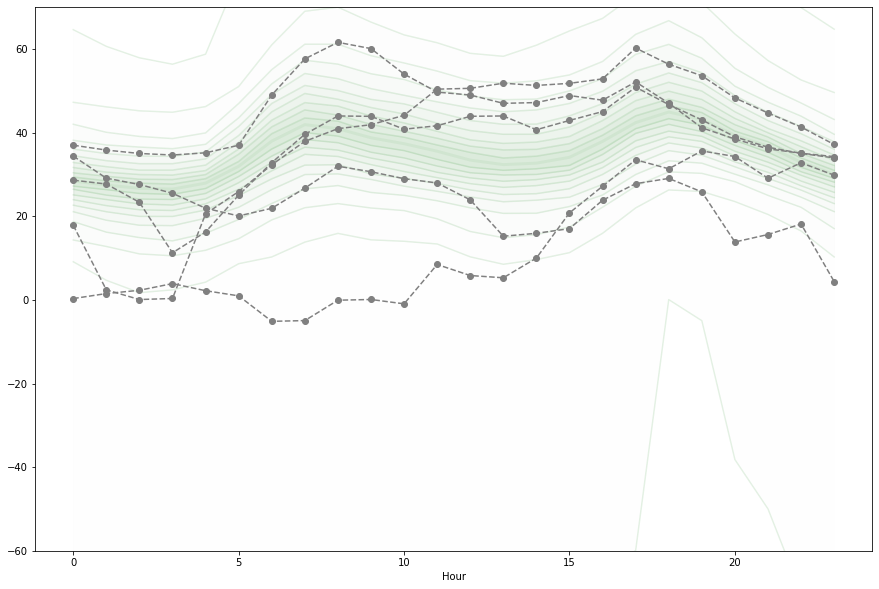

In [0]:
def dateRange(startDate, endDate):
  currentDate = startDate
  while (endDate > currentDate):
    currentDate = currentDate + dt.timedelta(days=1)
    yield currentDate

axes2 = quantilePlots(german_df, 10, 0.05, color='green')
plt.ylim(top=70, bottom=-60)

starting = dt.datetime(2019, 12, 10)
until = dt.datetime(2019, 12, 15)
for date in dateRange(starting, until):
  plotDailyAheadPrice(date, 'grey', axes2)

In [0]:
weekly_df = german_df.groupby(['Day of Week', 'Hour'], as_index=False).mean()

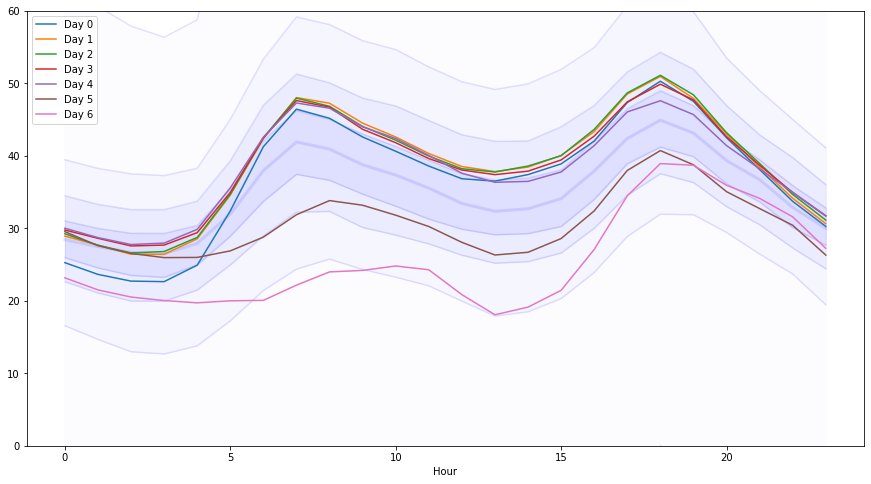

In [0]:
axes = quantilePlots(german_df, 4, 0.1, 'blue')
plt.ylim(top=60, bottom=0)
for day in range(7):
  weekly_df[weekly_df['Day of Week'] == day] \
  .rename(columns={'Day Ahead Price' : 'Day ' + str(day)}) \
  .plot.line('Hour', 'Day ' + str(day), ax=axes)

**Weekly patterns**

Sundays and Saturdays are off; does that lead to a change in pattern for those days?

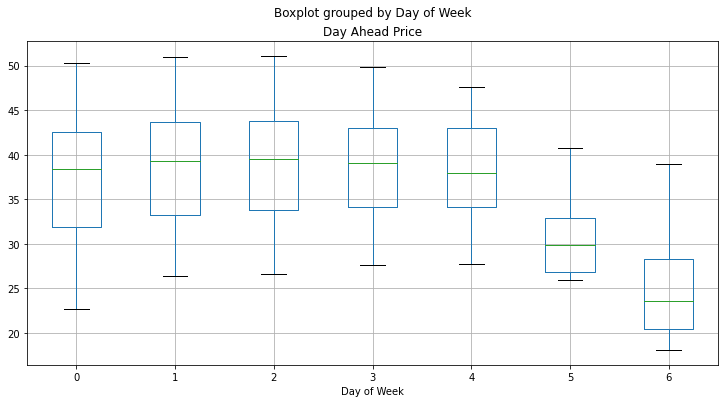

In [0]:
weekly_df.boxplot(column=['Day Ahead Price'], by='Day of Week', figsize=(12,6))

Seems the answer is yes.

**Monthly patterns**

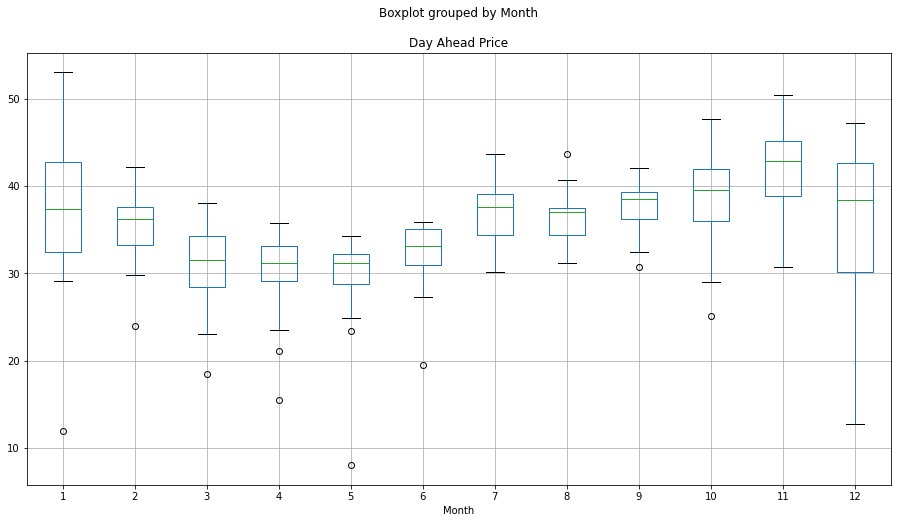

In [0]:
german_df.groupby(['Day', 'Month'], as_index=False).mean() \
  .boxplot(column=['Day Ahead Price'], by='Month', figsize=(15,8))

**Annual patterns**

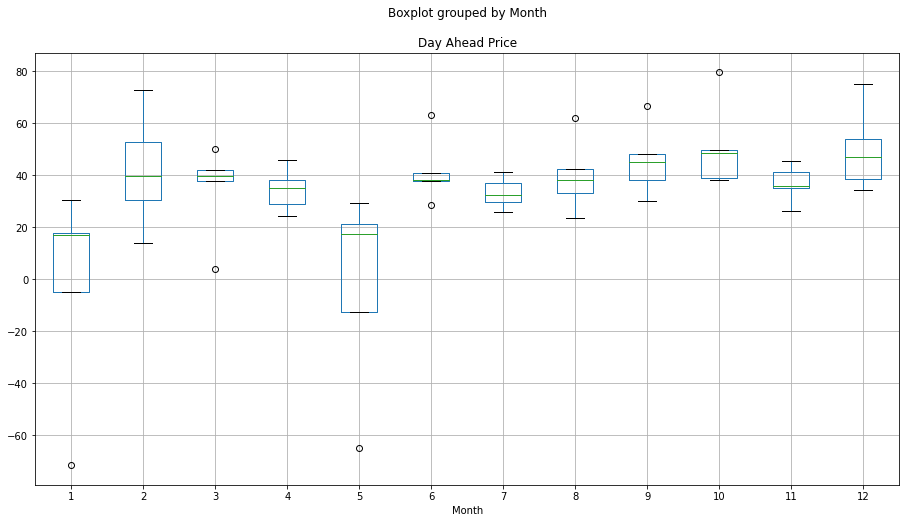

In [0]:
german_df[(german_df['Hour'] == 8) & (german_df['Day'] == 1)] \
.boxplot(column=['Day Ahead Price'], by='Month', figsize=(15,8))

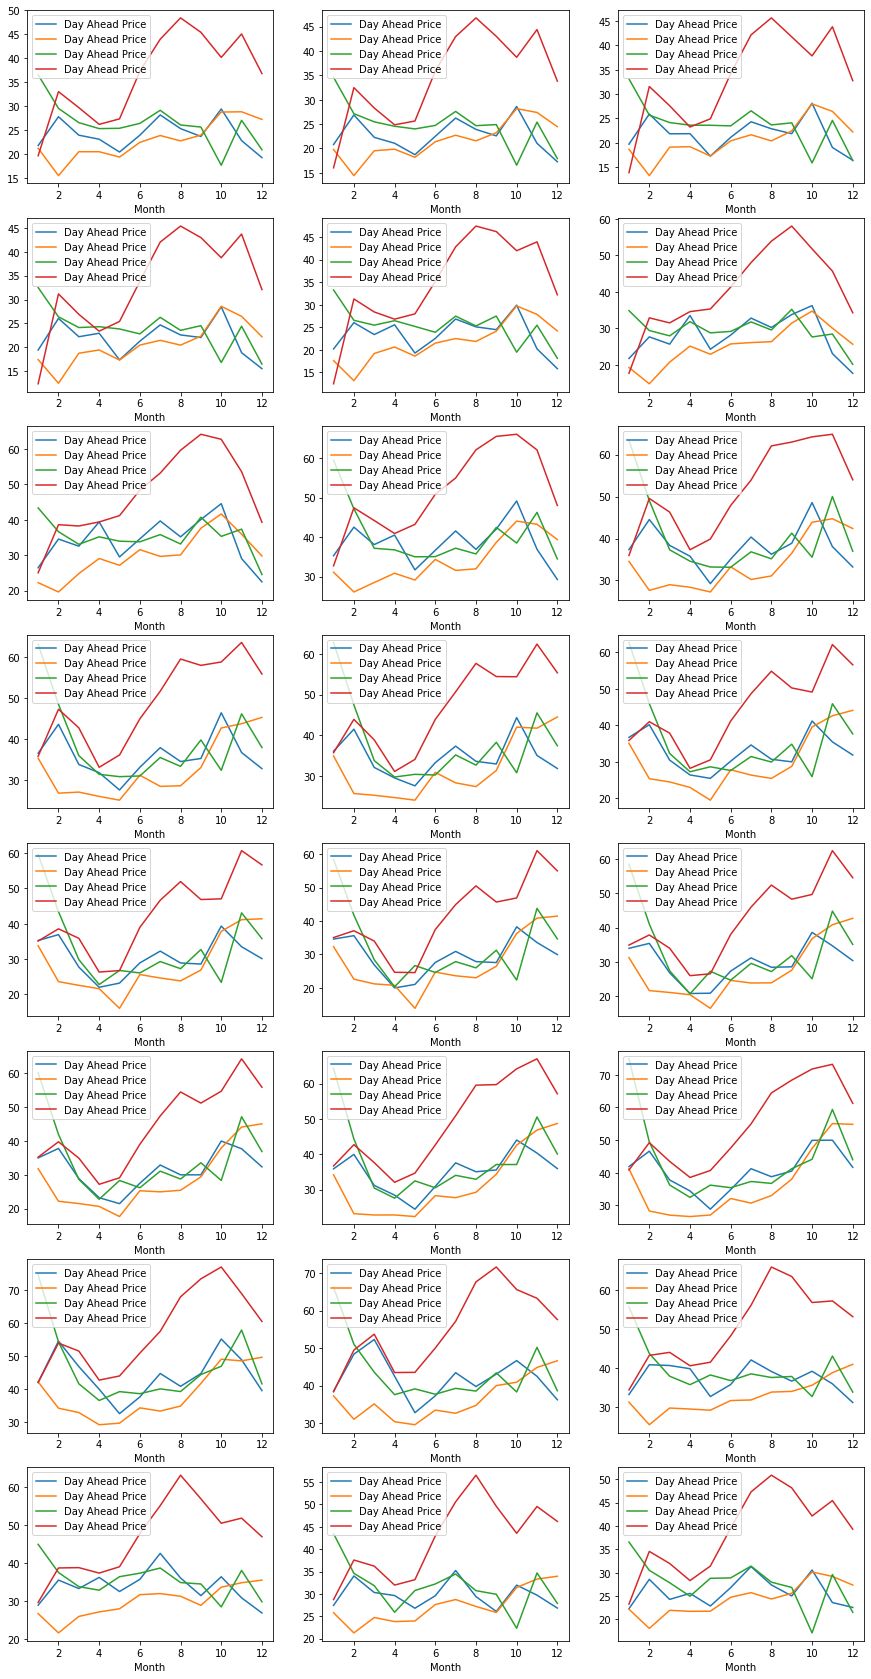

In [0]:
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(15,30))

for h in range(24):
  german_df_monthly = german_df[german_df['Hour'] == h].groupby(['Month', 'Year'], as_index=False).mean()
  for y in range(2015, 2019):
    german_df_monthly[german_df_monthly['Year'] == y].plot('Month', 'Day Ahead Price', ax=axes[h//3,h%3])

# Holidays and other predictable spikes

**Holidays** are slightly more complicated than just being a seasonal pattern. Some holidays are based on the lunar calendar, while some (for example, Easter) vary on an annual basis. But whether a day is a holiday or not affects demand, so it is useful to include this feature in our analysis. A quick search reveals python packages called `Holidays` and `Workalendar`; I would prefer to implement my own version, but due to time constraints, I have chosen `Workalendar`.

In [0]:
from workalendar.registry import registry
from collections import defaultdict

from_year = 2014
to_year = 2020

# our bidding zone consists of Austria (pre-2018), Germany and Luxembourg
calendars = registry.get_calendars(['AT', 'DE', 'LU'], include_subregions=True)
holidayDict = defaultdict(list)
countrySet = set()
for country, calendar in calendars.items():
  countrySet.add(country)
  temp_obj = calendar()
  for year in range(from_year, to_year):
    for holidayDate, holidayName in temp_obj.holidays(year):
      holidayDict[holidayDate].append((holidayName, country))

def get_holiday(chosenDate, region):
  holidays_on_date = holidayDict[chosenDate]
  for holiday, region_of_holiday in holidays_on_date:
    if region_of_holiday == region:
      return holiday
  return 'normal day'

for country in countrySet:
  german_df[country] = german_df['Date'].apply(lambda x: get_holiday(x.date(), country))

Let's plot an aggregrate plot of holidays vs. working days to see how much of an effect this feature really has.

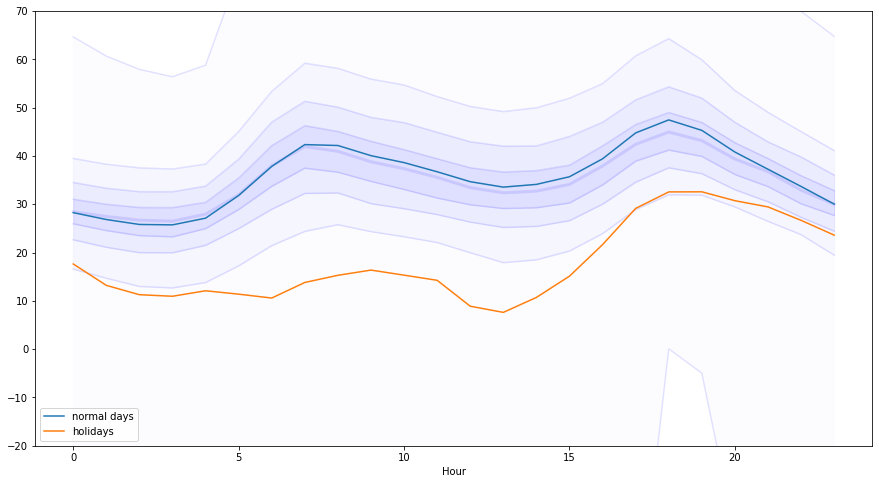

In [0]:
axes = quantilePlots(german_df, 4, 0.1, 'blue')

plt.ylim(top=70, bottom=-20)

german_df[german_df['DE'] == 'normal day'] \
  .groupby('Hour', as_index=False) \
  .mean() \
  .rename(columns={'Day Ahead Price' : 'normal days'}) \
  .plot('Hour', 'normal days', ax=axes)

german_df[german_df['DE'] != 'normal day'] \
  .groupby('Hour', as_index=False) \
  .mean() \
  .rename(columns={'Day Ahead Price' : 'holidays'}) \
  .plot('Hour', 'holidays', ax=axes)

That plot should convince you that accounting for holidays as a feature was indeed a good idea.

# [Sunrise and sunset]

**TODO**: Does daylight affect electricity consumption?

In [0]:
from astral import LocationInfo
from astral.sun import sun

city = LocationInfo("Berlin", "Germany", "Europe/Berlin", 52.5, 13.40)
s = sun(city.observer, date=dt.date(2020, 2, 28))
s['sunrise'].time()
s['sunset']

datetime.datetime(2020, 2, 28, 16, 42, 8, 140387, tzinfo=<UTC>)

# Exogenous series

Up until now, we have only considered features extracted from the primary time-series itself. For the next part, we want to consider exogenous time-series that can be considered in our analysis.

#### Day-ahead load and generation forecasts

Load and generation forecasts are given before the day-ahead prices are set, so they represent important features for estimating the day-ahead price. Further, picking up from ref. `[LRV18]`, it can even be argued that weather data and other features are already considered in this datapoint, so one can even forego considering those in favour of this. This is indeed the approach that I will take, but first it needs a bit of cleaning before it is useful.

##### Data cleaning

The data cleaning is the same as for our day-ahead price data, so we can just repeat the procedure. There are a few minor changes, but overall the idea remains the same.

In [48]:
root_path = 'energy-prediction/data/Germany/generation-forecast/'
genForecastDF1 = pd.read_csv(urljoin(root_path, 'Forecasted_generation_201501010000_201701012359_1.csv'), sep=';')
genForecastDF2 = pd.read_csv(urljoin(root_path, 'Forecasted_generation_201701010000_201901012359_1.csv'), sep=';')
genForecastDF3 = pd.read_csv(urljoin(root_path, 'Forecasted_generation_201901010000_202101012359_1.csv'), sep=';')

genForecastDF = genForecastDF1 \
  .append(genForecastDF2[genForecastDF2['Date'] != 'Jan 1, 2017']) \
  .append(genForecastDF3[genForecastDF3['Date'] != 'Jan 1, 2019'])

genForecastDF['Date'] = pd.to_datetime(genForecastDF['Date'])
genForecastDF['Time of day'] = pd.to_datetime(genForecastDF['Time of day']).dt.time
genForecastDF.replace('-', 'NaN', inplace=True)
for column in list(filter(lambda x: x.endswith('[MWh]'), genForecastDF.columns)):
  genForecastDF[column] = genForecastDF[column].apply(lambda x: float(x.replace(',', '')))

genForecastDF['timedate'] = pd.to_datetime(genForecastDF['Date'].astype('str') \
  + ' ' + genForecastDF['Time of day'].astype('str'))
genForecastDF.set_index('timedate', drop=True, inplace=True)
genForecastDF.index.name = None
genForecastDF.drop(columns=['Date', 'Time of day'], inplace=True)

# do the DST corrections
UTC_datetime_index = genForecastDF \
  .tz_localize(tz='Europe/Berlin', ambiguous='infer') \
  .index \
  .tz_convert(None)
CET_datetime_index = UTC_datetime_index + pd.to_timedelta(1, unit='h')
unique, counts = np.unique(CET_datetime_index.date, return_counts=True)
assert(np.all(counts == 96) == True) # Does each day have 24x4 forecasts?
genForecastDF.set_index(CET_datetime_index, inplace=True)

genForecastDF.sample(5)

,Total[MWh],Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],Other[MWh]
2018-01-22 14:15:00,NaN,344.0,2501.0,256.0,NaN
2018-09-08 13:45:00,NaN,970.5,2263.5,4724.0,NaN
2015-08-20 00:30:00,NaN,72.5,445.0,0.0,NaN
2016-07-06 08:30:00,NaN,678.0,5072.0,3272.0,NaN
2015-01-04 11:30:00,NaN,NaN,4011.0,1005.0,NaN


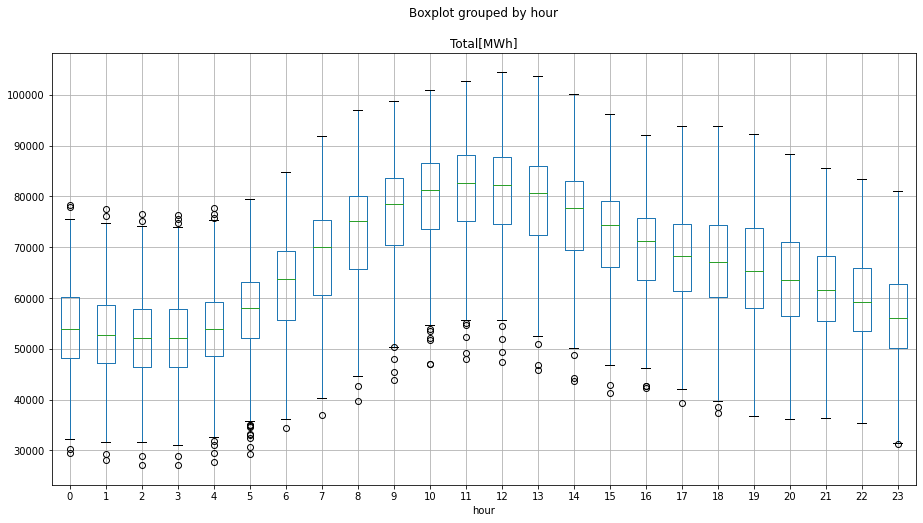

In [49]:
genForecastDF['hour'] = genForecastDF.index.hour
genForecastDF.boxplot('Total[MWh]', by='hour', figsize=(15,8))
genForecastDF.drop(columns='hour', inplace=True)

In [50]:
missing_values_index = np.unique(genForecastDF[genForecastDF['Wind offshore[MWh]'].isnull()].index.date).tolist()
group_contiguous_points(missing_values_index)

[(datetime.date(2015, 1, 4), datetime.date(2015, 1, 4))]

In [0]:
imputed_genForecastDF = impute(genForecastDF, 'Photovoltaics[MWh]', verbose=False)

The same procedure again, for the load generation forecast.

In [58]:
root_path = 'energy-prediction/data/Germany/load-forecast/'
loadForecastDF1 = pd.read_csv(urljoin(root_path, 'Forecasted_consumption_201501010000_201701012345_1.csv'), sep=';')
loadForecastDF2 = pd.read_csv(urljoin(root_path, 'Forecasted_consumption_201701010000_201901012345_1.csv'), sep=';')
loadForecastDF3 = pd.read_csv(urljoin(root_path, 'Forecasted_consumption_201901010000_202002082345_1.csv'), sep=';')
loadForecastDF = loadForecastDF1 \
  .append(loadForecastDF2[loadForecastDF2['Date'] != 'Jan 1, 2017']) \
  .append(pd.DataFrame([{'Date': 'Jan 1, 2017', 'Time of day': '12:45 PM', 'Total[MWh]': '-'}])) \
  .append(loadForecastDF3[loadForecastDF3['Date'] != 'Jan 1, 2019']) \
  .append(pd.DataFrame([{'Date': 'Jan 1, 2019', 'Time of day': '12:45 PM', 'Total[MWh]': '-'}]))
# somehow, exactly two values were missing, I assume it was some error on my part while downloading

loadForecastDF['Date'] = pd.to_datetime(loadForecastDF['Date'])
loadForecastDF['Time of day'] = pd.to_datetime(loadForecastDF['Time of day']).dt.time
loadForecastDF.replace('-', 'NaN', inplace=True)
for column in list(filter(lambda x: x.endswith('[MWh]'), loadForecastDF.columns)):
  loadForecastDF[column] = loadForecastDF[column].apply(lambda x: float(x.replace(',', '')))

# set key to datetime
loadForecastDF['timedate'] = pd.to_datetime(loadForecastDF['Date'] \
  .astype('str') + ' ' + loadForecastDF['Time of day'].astype('str'))
loadForecastDF.set_index('timedate', drop=True, inplace=True)
loadForecastDF.index.name = None
loadForecastDF.drop(columns=['Date', 'Time of day'], inplace=True)

# do the DST corrections
UTC_datetime_index = loadForecastDF \
  .tz_localize(tz='Europe/Berlin', ambiguous='infer') \
  .index \
  .tz_convert(None)
CET_datetime_index = UTC_datetime_index + pd.to_timedelta(1, unit='h')
unique, counts = np.unique(CET_datetime_index.date, return_counts=True)
assert(np.all(counts == 96) == True) # Does each day have 24x4 forecasts?
loadForecastDF.set_index(CET_datetime_index, inplace=True)

loadForecastDF.sample(5)

,Total[MWh]
2017-03-19 00:00:00,11271.00
2017-05-20 14:00:00,13103.00
2016-12-22 16:15:00,16176.25
2015-09-18 06:15:00,15668.75
2018-03-17 10:30:00,15283.00


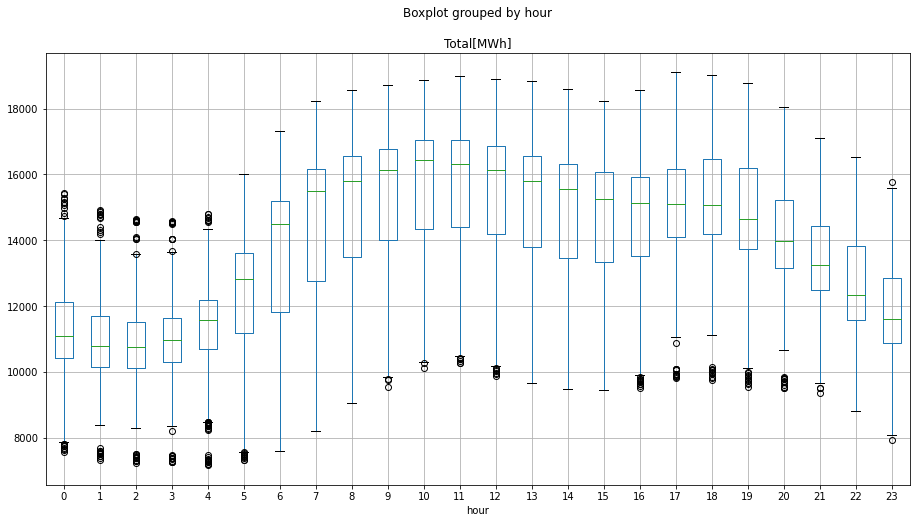

In [59]:
loadForecastDF['hour'] = loadForecastDF.index.hour
loadForecastDF.boxplot('Total[MWh]', by='hour', figsize=(15,8))
loadForecastDF.drop(columns='hour', inplace=True)

In [60]:
missing_values_index = np.unique(loadForecastDF[loadForecastDF['Total[MWh]'].isnull()].index.date).tolist()
group_contiguous_points(missing_values_index)

[(datetime.date(2015, 9, 25), datetime.date(2015, 9, 27)),
 (datetime.date(2016, 8, 5), datetime.date(2016, 8, 6)),
 (datetime.date(2016, 11, 1), datetime.date(2016, 11, 1)),
 (datetime.date(2017, 1, 1), datetime.date(2017, 1, 1)),
 (datetime.date(2017, 7, 19), datetime.date(2017, 7, 20)),
 (datetime.date(2018, 7, 12), datetime.date(2018, 7, 13)),
 (datetime.date(2018, 9, 23), datetime.date(2018, 9, 24)),
 (datetime.date(2019, 1, 1), datetime.date(2019, 1, 1)),
 (datetime.date(2019, 3, 9), datetime.date(2019, 3, 9)),
 (datetime.date(2019, 4, 13), datetime.date(2019, 4, 14)),
 (datetime.date(2019, 6, 10), datetime.date(2019, 6, 11)),
 (datetime.date(2019, 9, 8), datetime.date(2019, 9, 9)),
 (datetime.date(2019, 9, 11), datetime.date(2019, 9, 12)),
 (datetime.date(2019, 10, 19), datetime.date(2019, 10, 20)),
 (datetime.date(2019, 12, 21), datetime.date(2019, 12, 21)),
 (datetime.date(2020, 1, 31), datetime.date(2020, 1, 31))]

In [61]:
imputed_loadForecastDF = impute(loadForecastDF, 'Total[MWh]')

00:00:00
2015-09-26 00:00:00 imputed
2015-09-27 00:00:00 imputed
2016-08-06 00:00:00 imputed
2016-11-01 00:00:00 imputed
2017-07-20 00:00:00 imputed
2018-07-13 00:00:00 imputed
2018-09-24 00:00:00 imputed
2019-03-09 00:00:00 imputed
2019-04-14 00:00:00 imputed
2019-06-11 00:00:00 imputed
2019-09-09 00:00:00 imputed
2019-09-12 00:00:00 imputed
2019-10-20 00:00:00 imputed
2019-12-21 00:00:00 imputed
2020-01-31 00:00:00 imputed
00:15:00
2015-09-26 00:15:00 imputed
2015-09-27 00:15:00 imputed
2016-08-06 00:15:00 imputed
2016-11-01 00:15:00 imputed
2017-07-20 00:15:00 imputed
2018-07-13 00:15:00 imputed
2018-09-24 00:15:00 imputed
2019-03-09 00:15:00 imputed
2019-04-14 00:15:00 imputed
2019-06-11 00:15:00 imputed
2019-09-09 00:15:00 imputed
2019-09-12 00:15:00 imputed
2019-10-20 00:15:00 imputed
2019-12-21 00:15:00 imputed
2020-01-31 00:15:00 imputed
00:30:00
2015-09-26 00:30:00 imputed
2015-09-27 00:30:00 imputed
2016-08-06 00:30:00 imputed
2016-11-01 00:30:00 imputed
2017-07-20 00:30:00 i

##### Combining the datasets

We want to join these datasets to the `german_df` that we have. But note that it has a different resolution from the price dataset: the load and generation forecast are given for every 15 minutes, while the prices are given hourly. For simplicity and a lack of better idea, I will just take the average for the load and generation forecast grouped by hour, and concatenate it to the original dataframe.

In [0]:
loadForecastDF['Date'] = loadForecastDF.index.date
loadForecastDF['Time'] = loadForecastDF.index.time
genForecastDF['Date'] = genForecastDF.index.date
genForecastDF['Time'] = genForecastDF.index.time

In [0]:
groupedLoad = loadForecastDF \
  .groupby([loadForecastDF.index.date, loadForecastDF.index.hour])
load_to_joinDF = groupedLoad.agg({
    'Total[MWh]' : 'mean',
    'Date' : 'min',
    'Time' : 'min'
})

load_to_joinDF['timedate'] = pd.to_datetime(load_to_joinDF['Date'].astype('str') \
                                            + ' ' \
                                            + load_to_joinDF['Time'].astype('str'))
load_to_joinDF.set_index('timedate', drop=True, inplace=True)
load_to_joinDF.index.name = None

groupedGen = genForecastDF \
  .groupby([genForecastDF.index.date, genForecastDF.index.hour])
gen_to_joinDF = groupedGen.agg({
    'Total[MWh]' : 'mean',
    'Wind offshore[MWh]' : 'mean',
    'Wind onshore[MWh]' : 'mean',
    'Photovoltaics[MWh]' : 'mean',
    'Other[MWh]' : 'mean',
    'Date' : 'min',
    'Time' : 'min'
})

gen_to_joinDF['timedate'] = pd.to_datetime(gen_to_joinDF['Date'].astype('str') \
                                           + ' ' \
                                           + gen_to_joinDF['Time'].astype('str'))
gen_to_joinDF.set_index('timedate', drop=True, inplace=True)
gen_to_joinDF.index.name = None

In [0]:
load_to_joinDF.rename(columns={'Total[MWh]' : 'Total Load'}, inplace=True)
power_sources = list(filter(lambda x: x.endswith('[MWh]'), sorted(gen_to_joinDF)))
renamed_power_sources = list(map(lambda x: x[:-5] + ' Generation', power_sources))

gen_to_joinDF.rename(columns=dict(zip(power_sources, renamed_power_sources)), inplace=True)

In [0]:
# does an inner join
columns_for_join = {
    'load' : 'Total Load',
    'gen' : renamed_power_sources
}
german_df_with_load = german_df \
  .join(load_to_joinDF[columns_for_join['load']])
german_df_with_load_and_gen = german_df_with_load. \
  join(gen_to_joinDF[columns_for_join['gen']])

In [0]:
german_df_with_load_and_gen.sample(5)

,Daylight Savings Time,Day Ahead Price,Bidding Zone,Total Load,Other Generation,Photovoltaics Generation,Total Generation,Wind offshore Generation,Wind onshore Generation
2018-02-01 21:00:00,0,36.95,DE-AT-LU,16030.6875,52278.0,0.0000,75910.0,815.750,5092.2500
2016-03-04 20:00:00,0,27.90,DE-AT-LU,15485.7500,61731.0,0.0000,74616.0,603.000,2618.7500
2019-05-14 18:00:00,1,47.91,DE-LU,14657.5625,42569.5,595.6875,57183.0,63.125,2994.5625
2017-10-23 11:00:00,1,43.16,DE-AT-LU,17078.1875,69921.0,1179.7500,84763.0,142.250,2389.0000
2020-01-24 14:00:00,0,52.00,DE-LU,16800.0000,63943.0,1773.5000,78006.0,676.000,1066.7500


# How do neighbouring markets affect the price?

The importance of accounting for neighbouring market prices is well described in `[LRV18]`.

# Conclusion
That's it. We finally save it in `hdf5` format for later use.

In [0]:
german_df_with_load_and_gen.to_hdf('clean_german_df', key='df_with_load_and_gen')

# Bibliography
 
**[You12]** Electricity storage is not possible efficiently at a large scale yet, but there are some interesting ideas out there for sure. For example, see flywheels: https://www.youtube.com/watch?v=7K4W4hA6aV4.

**[LRV18]** J. Lago, F. D. Ridder, P. Vrancx, B. D. Schutter, *Forecasting day-ahead electricity prices in Europe: the importance of considering market integration*, Applied Energy 211 (2018) 890-903.

**[SMARD].** https://www.smard.de/en/topic-article/5870/9846   

Supplements:  
[Strategies for Daylight Savings Time]()

Next part: [Statistical models]()